In [2]:
!pip install talos

  Using cached https://files.pythonhosted.org/packages/f0/4e/85014772bbf026903080beecb36681dbceb28b14f96491f42673b95ddcf6/chances-0.1.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f4/66/586b63536bc578a6d28ffc1114959f51b2ca1a9582f9b987206b3ba9aa86/geonamescache-1.0.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8c/10/79282747f9169f21c053c562a0baa21815a8c7879be97abd930dbcf862e8/setuptools-39.1.0-py2.py3-none-any.whl
  Found existing installation: setuptools 40.4.3
    Uninstalling setuptools-40.4.3:
      Successfully uninstalled setuptools-40.4.3
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
# https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=aFe4wHGRFKle
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
import talos as ta
random.seed(42)

Using TensorFlow backend.


In [2]:
# https://github.com/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20on%20Keras%20with%20Breast%20Cancer%20Data.ipynb
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer


import pandas as pd

from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D

# Keras items
from keras.optimizers import Adam, SGD, RMSprop
from keras.activations import relu, elu, softmax
from keras.losses import logcosh, categorical_crossentropy, sparse_categorical_crossentropy
from keras.callbacks import History 
from keras.callbacks import ModelCheckpoint
from keras.metrics import categorical_accuracy, sparse_categorical_accuracy
%matplotlib inline


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
type(x_train)

numpy.ndarray

In [13]:
#x, y = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


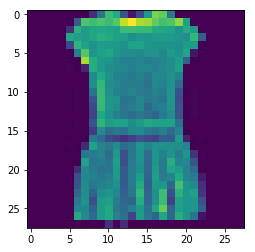

In [15]:
# Show one of the images from the training dataset
plt.imshow(x_train[3])

In [16]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [17]:
print("Number of train data - " + str(len(x_train)))
print("Number of test data - " + str(len(x_test)))

Number of train data - 60000
Number of test data - 10000


In [18]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


In [19]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
# first we have to make sure to input data and params into the function
def fashion_mnist_model(x_train, y_train, x_val, y_val, params):
    %%time
    model = Sequential()
    
    model.add(Conv2D(filters=params['first_neuron'], kernel_size=2, padding='same', activation=params['activation'], input_shape=(28,28,1))) 
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(params['dropout']))

    model.add(Conv2D(filters=params['first_neuron'], kernel_size=2, padding='same', activation=params['activation']))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(params['dropout']))

    model.add(Flatten())
    model.add(Dense(128, activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(10, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  metrics=['accuracy'])
    
    #checkpointer = ModelCheckpoint(filepath='model.weights.hdf5', verbose = 2, save_best_only=False)

    history = model.fit(x_train,
                        y_train, 
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        validation_data=[x_val, y_val],
                        callbacks=[live()])                        
                        #callbacks=[checkpointer])

    return history, model

# ACTUAL PARAMETERS DO NOT DELETE
# then we can go ahead and set the parameter space
p = {'lr': (0.1, 0.25, 0.50, 0.75, 1.00),
     'first_neuron': [8, 16, 32, 64],
     'hidden_layers': [1],
     'batch_size': [8, 16, 32],
     'epochs': [5, 10, 15, 20],
     'dropout': [0.25, .50, .75],
     'kernel_initializer': ['normal'],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'optimizer': [Adam, SGD, RMSprop],
     'losses': [categorical_crossentropy],
     'activation':[relu],
     'last_activation': ['softmax']}

In [24]:
# ACTUAL PARAMETERS DO NOT DELETE
# then we can go ahead and set the parameter space
p = {'lr': (0.1, 0.25),
     'first_neuron': [8, 16],
     'hidden_layers': [1],
     'batch_size': [32, 16],
     'epochs': [5],
     'dropout': [0.25],
     'kernel_initializer': ['normal'],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'optimizer': [Adam],
     'losses': [categorical_crossentropy],
     'activation':[relu],
     'last_activation': ['softmax']}

In [25]:
# ACTUAL SCAN DO NOT DELETE
# and run the experiment
%time
t = ta.Scan(x=x_train,
            y=y_train,
            model=fashion_mnist_model,
            grid_downsample=1.0, 
            params=p,
            dataset_name='fashion_mnist',
            experiment_no='1',
            seed=42,
            x_val=x_test,
            y_val=y_test
           )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


IndexError: tuple index out of range

In [ ]:
# Check the shape of the x values
t.x.shape

In [ ]:
t.x.shape[0]

In [ ]:
t.y.shape

In [ ]:
t.x.shape[1]

In [ ]:
t.x.shape[2]

In [ ]:
#https://stackoverflow.com/questions/32838802/numpy-with-python-convert-3d-array-to-2d
w, h = 28, 28
#t.x = t.x.reshape(t.x.shape[0], w*h)
t.x = t.x.reshape(t.x.shape[0], t.x.shape[1]*t.x.shape[2])
t.x = t.x.transpose()
t.x.shape

In [ ]:
from talos import Deploy
ta.Deploy(t, 'FinalModels', metric='val_acc');

In [5]:
from talos import Restore
restored_model = Restore('FinalModels3.zip')

In [6]:
# https://autonomio.github.io/docs_talos/#reporting
from talos import Reporting
r = Reporting('fashion_mnist_3.csv')
r.data

,round_epochs,val_loss,val_acc,loss,acc,lr,first_neuron,hidden_layers,batch_size,epochs,dropout,kernel_initializer,weight_regulizer,emb_output_dims,optimizer,losses,activation,last_activation
0,15,0.323975,0.8978,0.321722,0.889218,0.1,64,1,16,15,0.25,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
1,10,0.469715,0.8303,0.572706,0.785109,0.1,16,3,32,10,0.50,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
2,20,0.296557,0.8920,0.344143,0.874945,0.1,64,2,32,20,0.50,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
3,10,0.620522,0.7679,0.705569,0.727236,0.1,16,3,16,10,0.25,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
4,5,0.474112,0.8304,0.584776,0.781436,0.1,16,1,8,5,0.50,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
5,15,0.837934,0.7119,0.966794,0.616545,0.1,16,2,32,15,0.50,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
6,5,0.354560,0.8694,0.371052,0.870400,0.1,64,2,16,5,0.25,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
7,5,0.396754,0.8574,0.444975,0.840236,0.1,32,3,32,5,0.25,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
8,15,0.696838,0.7287,0.793392,0.686800,0.1,32,2,16,15,0.50,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax
9,20,0.601136,0.7828,0.727454,0.720127,0.1,16,1,16,20,0.50,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x7f6332...,<function relu at 0x7f6332bb4ae8>,softmax


In [6]:
# returns the highest value for 'acc'
r.high('val_acc')

0.9158

In [7]:
# returns the number of rounds it took to find best model
r.rounds2high('val_acc')

80

In [ ]:
# returns the saved models (json)
t.saved_models

In [ ]:
# returns the saved model weights
t.saved_weights

In [8]:
# returns the epoch entropy dataframe
t.peak_epochs_df

NameError: name 't' is not defined

In [ ]:
# returns the results dataframe
t.data

In [ ]:
# returns the experiment configuration details
t.details

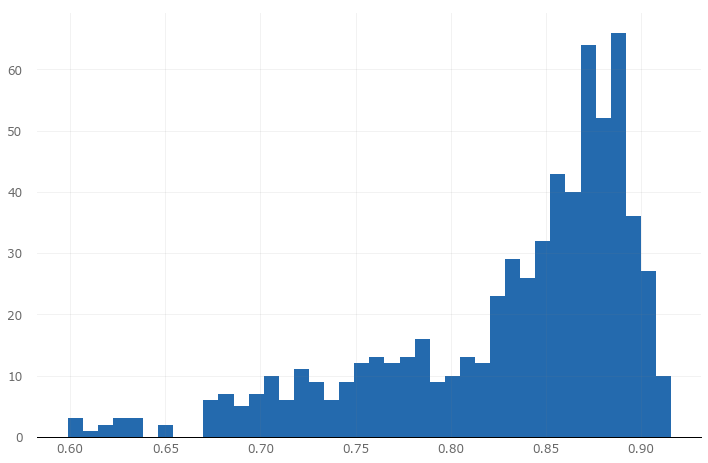

In [21]:
# A histogram for a given metric where each observation is a permutation
r.plot_hist('val_acc', bins=40)

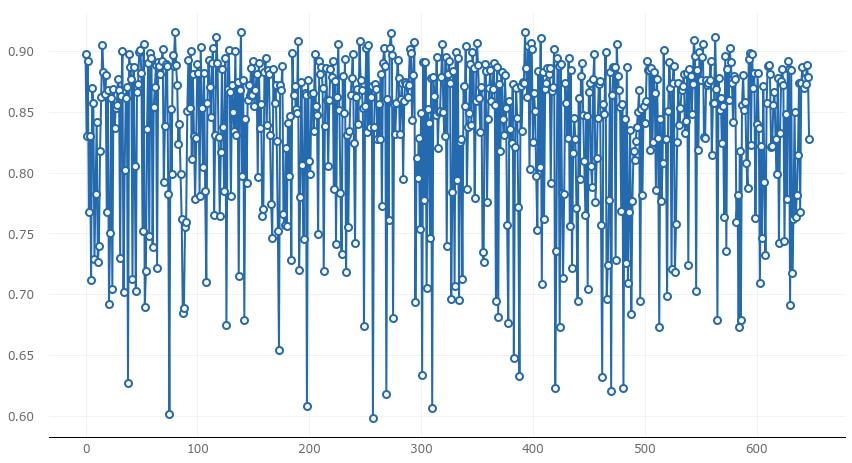

In [11]:
# A round-by-round line graph for a given metric
r.plot_line('val_acc')

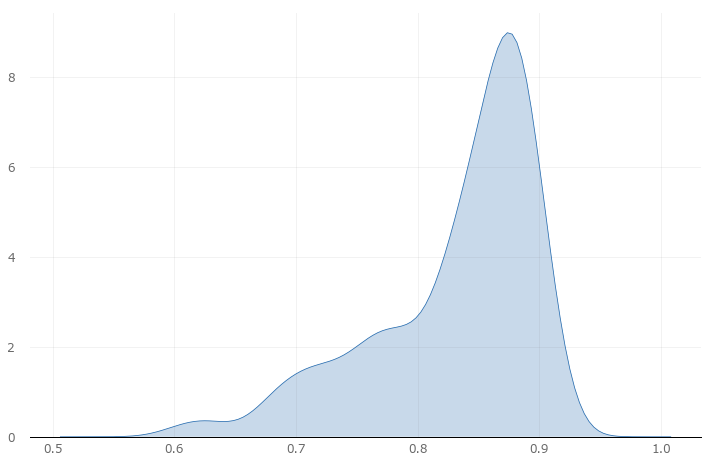

In [10]:
# up to two dimensional kernel density estimator
r.plot_kde('val_acc')

In [11]:
restored_model.params

{'lr': (0.1, 0.25, 0.5),
 'first_neuron': [16, 32, 64],
 'hidden_layers': [1, 2, 3],
 'batch_size': [8, 16, 32],
 'epochs': [5, 10, 15, 20],
 'dropout': [0.25, 0.5],
 'kernel_initializer': ['normal'],
 'weight_regulizer': [None],
 'emb_output_dims': [None],
 'optimizer': [keras.optimizers.Adam,
  keras.optimizers.SGD,
  keras.optimizers.RMSprop],
 'losses': [<function keras.losses.categorical_crossentropy(y_true, y_pred)>],
 'activation': [<function keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)>],
 'last_activation': ['softmax']}

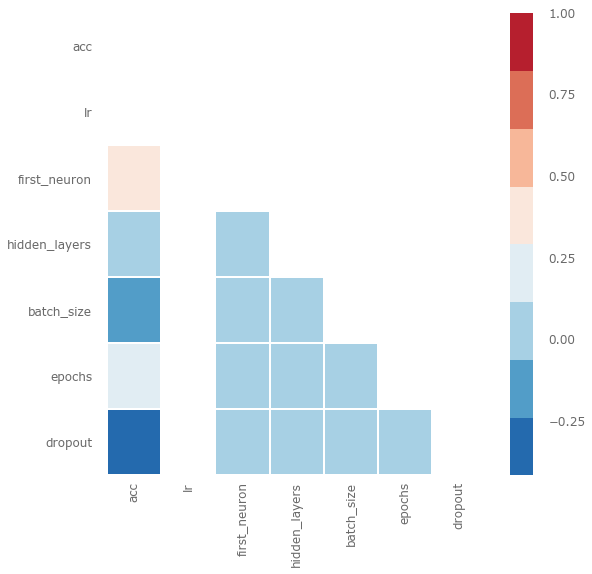

In [8]:
# A correlation heatmap where a single metric is compared against hyperparameters
r.plot_corr('acc')

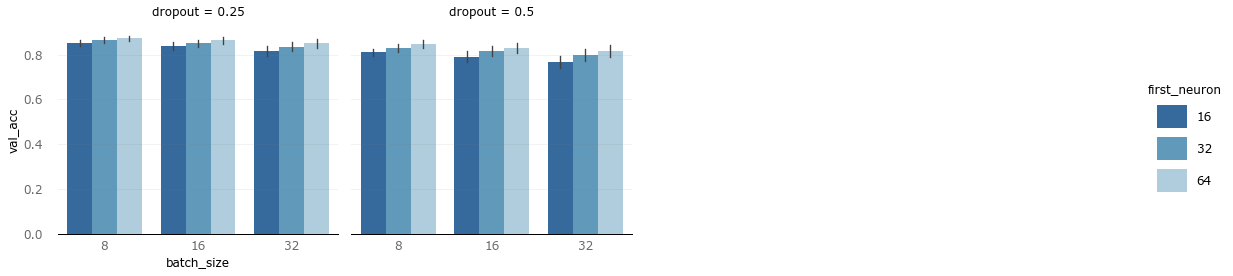

In [14]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'dropout')

In [ ]:
#from talos import Predict, Evaluate
# https://autonomio.github.io/docs_talos/#predict
#p = Predict(t)
#r.best_model(metric='val_acc')
#r.predict(x_test)
#r.evaluate(x_test, y_test, folds=10, average='macro')

In [ ]:
# https://autonomio.github.io/docs_talos/#evaluate
from talos import Predict, Evaluate
e = Evaluate(t)
e.evaluate(x_test, y_test, average='macro', metric='val_acc')

In [ ]:
restored_model.model.predict(x_test)

In [6]:
restored_model.details

,0,1
0,complete_time,10/15/18/07:23
1,experiment_name,fashion_mnist_1
2,grid_downsample,1.0
3,random_method,uniform_mersenne
4,reduce_loss,False
5,reduction_interval,50
6,reduction_method,NaN
7,reduction_metric,val_acc
8,reduction_threshold,0.2
9,reduction_window,20


In [7]:
restored_model.params

{'lr': (0.1, 0.25, 0.5, 0.75, 1.0),
 'first_neuron': [8, 16, 32, 64],
 'hidden_layers': [1],
 'batch_size': [8, 16, 32],
 'epochs': [5, 10, 15, 20],
 'dropout': [0.25, 0.5, 0.75],
 'kernel_initializer': ['normal'],
 'weight_regulizer': [None],
 'emb_output_dims': [None],
 'optimizer': [keras.optimizers.Adam,
  keras.optimizers.SGD,
  keras.optimizers.RMSprop],
 'losses': [<function keras.losses.categorical_crossentropy(y_true, y_pred)>],
 'activation': [<function keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)>],
 'last_activation': ['softmax']}

In [8]:
restored_model.results

,round_epochs,val_loss,val_acc,loss,acc,lr,first_neuron,hidden_layers,batch_size,epochs,dropout,kernel_initializer,weight_regulizer,emb_output_dims,optimizer,losses,activation,last_activation
0,10,0.532615,0.8478,0.538523,0.813036,0.1,32,1,8,10,0.50,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
1,20,0.297641,0.8944,0.366232,0.866182,0.1,32,1,8,20,0.50,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
2,5,1.250623,0.5951,1.342336,0.466164,0.1,8,1,32,5,0.75,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
3,15,1.011150,0.6111,1.145715,0.534145,0.1,64,1,32,15,0.75,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
4,5,0.468906,0.8318,0.569771,0.788073,0.1,32,1,32,5,0.50,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
5,5,0.335368,0.8792,0.345031,0.875545,0.1,64,1,16,5,0.25,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
6,20,0.249844,0.9080,0.255427,0.906927,0.1,32,1,8,20,0.25,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
7,10,0.744760,0.7429,0.843847,0.708436,0.1,32,1,8,10,0.75,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
8,10,0.782556,0.6997,0.874101,0.659364,0.1,64,1,32,10,0.50,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax
9,15,0.361661,0.8696,0.441733,0.838364,0.1,32,1,32,15,0.50,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7fa5b3...,<function relu at 0x7fa5b3e691e0>,softmax


In [10]:
restored_model.x

,0,1,2,3,4,5,6,7,8,9,...,54990,54991,54992,54993,54994,54995,54996,54997,54998,54999
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
6,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
7,0.000000,0.172549,0.0,0.0,0.0,0.0,0.000000,0.003922,0.000000,0.003922,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
8,0.000000,0.215686,0.0,0.0,0.0,0.0,0.003922,0.003922,0.000000,0.000000,...,0.003922,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
9,0.000000,0.376471,0.0,0.0,0.0,0.0,0.003922,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.019608,0.000000,0.0


In [11]:
restored_model.y

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Given a greyscale image of a piece of clothing and a threshold accuracy of 90%, minimize the training time for a convolutional neural network.


In [27]:
from talos import Reporting
r = Reporting('FinalModels/FinalModels_results.csv')

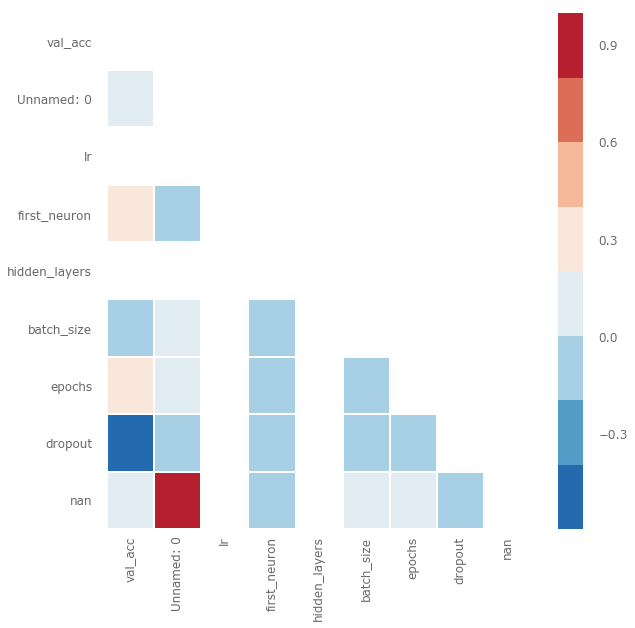

In [36]:
r.plot_corr()

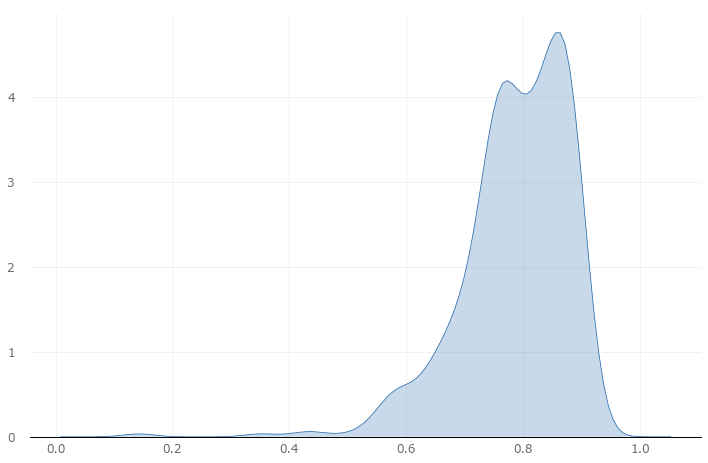

In [29]:
r.plot_kde('val_acc')

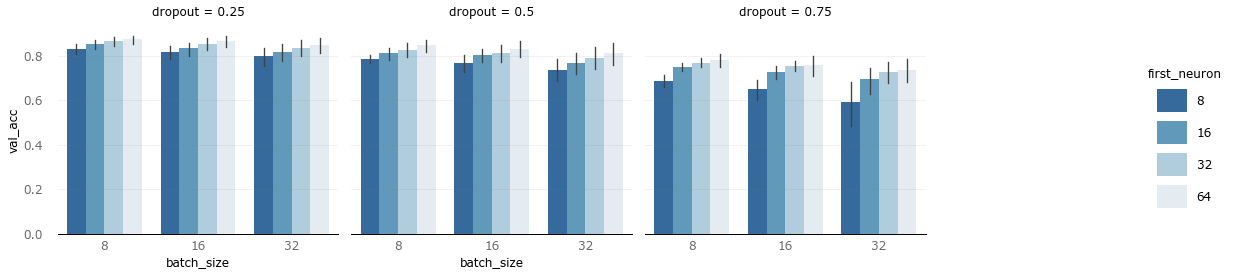

In [30]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'dropout')

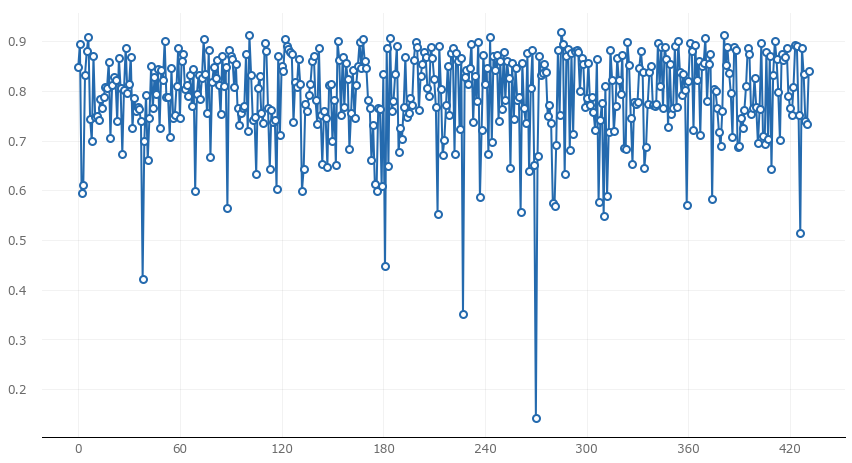

In [31]:
# A round-by-round line graph for a given metric
r.plot_line('val_acc')

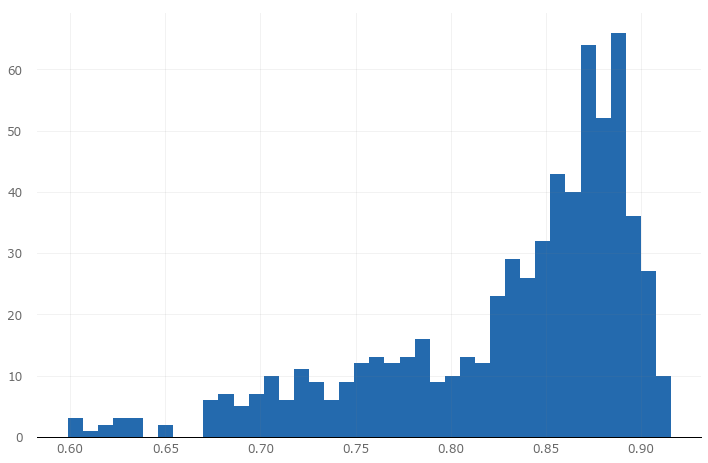

In [17]:
# A histogram for a given metric where each observation is a permutation
r.plot_hist('val_acc', bins=40)

In [3]:
DF = pd.read_csv('fashion_mnist_3.csv')

In [5]:
DF.columns

Index(['round_epochs', 'val_loss', 'val_acc', 'loss', 'acc', 'lr',
       'first_neuron', 'hidden_layers', 'batch_size', 'epochs', 'dropout',
       'kernel_initializer', 'weight_regulizer', 'emb_output_dims',
       'optimizer', 'losses', 'activation', 'last_activation'],
      dtype='object')

In [7]:
DF2 = DF[['val_acc',
         'first_neuron',
         'hidden_layers',
         'batch_size',
         'epochs', 
         'dropout',
         'optimizer'
        ]]

In [8]:
DF2.columns

Index(['val_acc', 'first_neuron', 'hidden_layers', 'batch_size', 'epochs',
       'dropout', 'optimizer'],
      dtype='object')

In [9]:
DF2.shape

(648, 7)

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
DF2.columns

Index(['val_acc', 'first_neuron', 'hidden_layers', 'batch_size', 'epochs',
       'dropout', 'optimizer'],
      dtype='object')

In [14]:
type(DF2['optimizer'])

pandas.core.series.Series

In [15]:
enc = OneHotEncoder(handle_unknown='ignore')

In [22]:
DF_ENCODED = enc.fit(DF2, categorical_features='optimizer')

TypeError: fit() got an unexpected keyword argument 'categorical_features'

In [20]:
DF_ENCODED.categories_

[array([0.5987, 0.6017, 0.6066, 0.6078, 0.6181, 0.6204, 0.6231, 0.6232,
        0.6268, 0.6323, 0.6328, 0.6338, 0.6475, 0.6538, 0.6728, 0.6732,
        0.6734, 0.6743, 0.6745, 0.6762, 0.6786, 0.6792, 0.6807, 0.6813,
        0.684, 0.6845, 0.6886, 0.6894, 0.6914, 0.6924, 0.6937, 0.6942,
        0.6944, 0.6945, 0.6952, 0.6958, 0.6964, 0.6985, 0.7019, 0.703,
        0.7040000000000001, 0.7041, 0.7052, 0.7068, 0.7088, 0.7089, 0.7092,
        0.7099, 0.7119, 0.7125, 0.7127, 0.7136, 0.7154, 0.7179, 0.7183,
        0.7187, 0.7191, 0.7193, 0.7203, 0.7211, 0.7216, 0.7217, 0.7241,
        0.7244, 0.7257, 0.7266, 0.7268, 0.7281, 0.7286, 0.7287, 0.7301,
        0.7325, 0.7328, 0.7346, 0.7353, 0.7358, 0.7392, 0.7396, 0.7401,
        0.7416, 0.7425, 0.7438, 0.7458, 0.7459, 0.746, 0.7461, 0.7482,
        0.7498, 0.7507, 0.7517, 0.7521, 0.7532, 0.7538, 0.7554, 0.7557,
        0.7559, 0.7562, 0.7568, 0.7569, 0.7573, 0.7575, 0.7591, 0.7593,
        0.7614, 0.7616, 0.7618, 0.7619, 0.7627, 0.7638, 0.7639,

In [24]:
DF2['optimizer'] == "<class 'keras.optimizers.RMSprop'>"

0       True
1      False
2      False
3      False
4      False
5      False
6       True
7       True
8      False
9      False
10     False
11     False
12     False
13     False
14      True
15     False
16     False
17      True
18      True
19     False
20      True
21     False
22     False
23     False
24     False
25      True
26     False
27     False
28     False
29      True
       ...  
618    False
619    False
620    False
621     True
622    False
623    False
624     True
625    False
626    False
627    False
628    False
629     True
630    False
631    False
632    False
633    False
634     True
635    False
636    False
637    False
638     True
639    False
640    False
641     True
642    False
643    False
644    False
645     True
646     True
647    False
Name: optimizer, Length: 648, dtype: bool